In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage.measurements import label
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

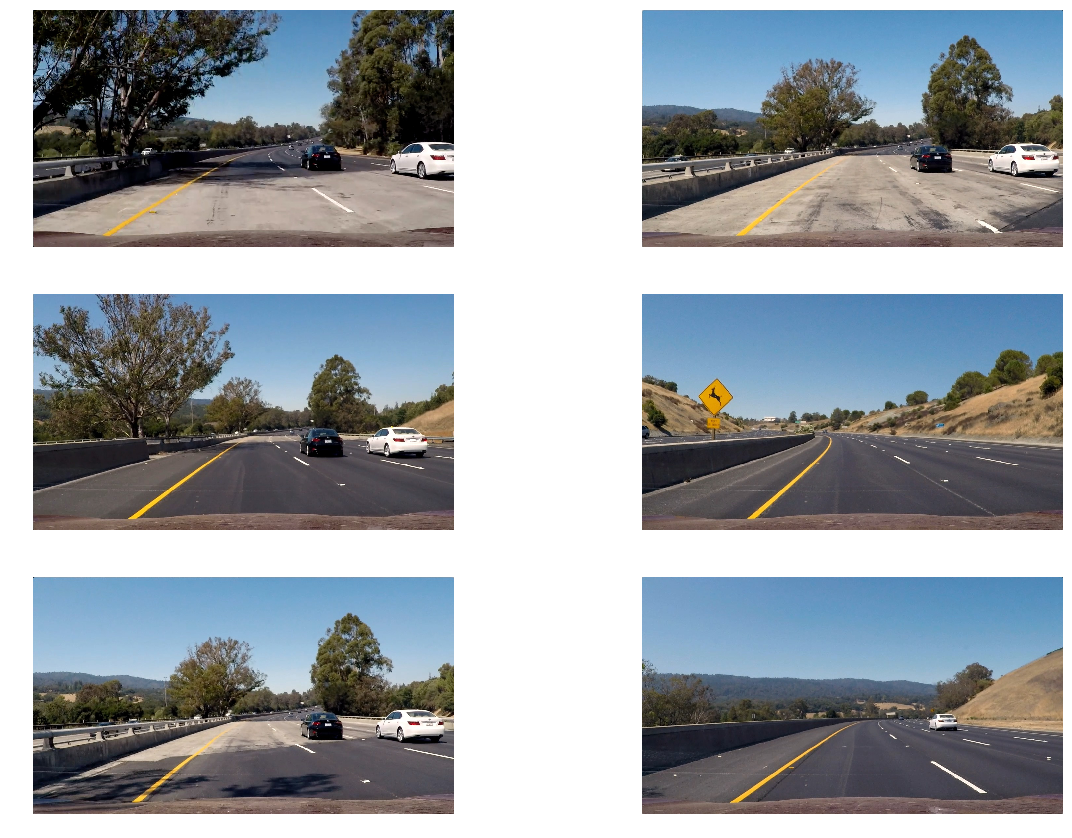

In [2]:
test_imgs   = glob.glob('./test_images/*.jpg')
counter =1
plt.figure(figsize=(20,20))
for i in test_imgs:
    img = mpimg.imread(i)
    plt.subplot(4,2,counter)
    plt.imshow(img)
    plt.axis("off")
    counter+=1
plt.show()

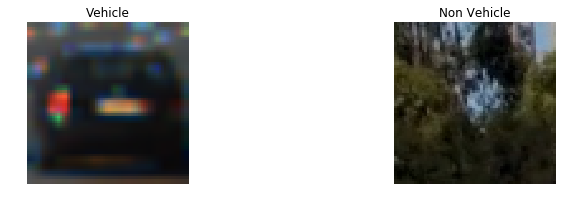

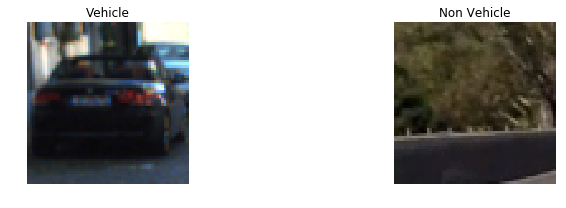

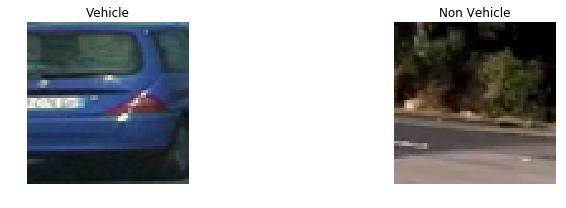

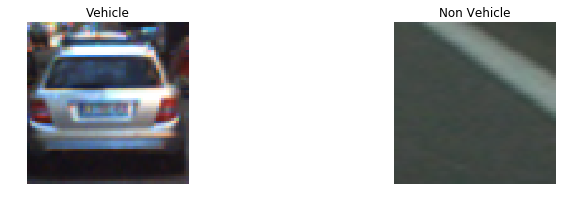

In [47]:
#### TRAINING DATA #####
cars   = glob.glob('./vehicles/**/*.png')
notcars= glob.glob('./non-vehicles/**/*.png')

# Plot the examples

indices = np.random.randint(0, len(cars), 4)
for i in indices:
    img_car = mpimg.imread(cars[i])
    img_notcar = mpimg.imread(notcars[i])    
    fig = plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.imshow(img_car)
    plt.title('Vehicle')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(img_notcar)
    plt.title('Non Vehicle')
    plt.axis('off')
    fig.savefig('training data visualization.png', bbox_inches='tight')
    plt.tight_layout()
plt.show()


In [10]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)


In [19]:
indices = np.random.randint(0, len(cars), 2)
train_vis_images = []
print(indices)
for i in indices:
    img_car = mpimg.imread(cars[i])
    img_notcar = mpimg.imread(notcars[i])
    train_vis_images.append(img_car)
    train_vis_images.append(img_notcar)
print(len(train_vis_images))

[ 249 2412]
4


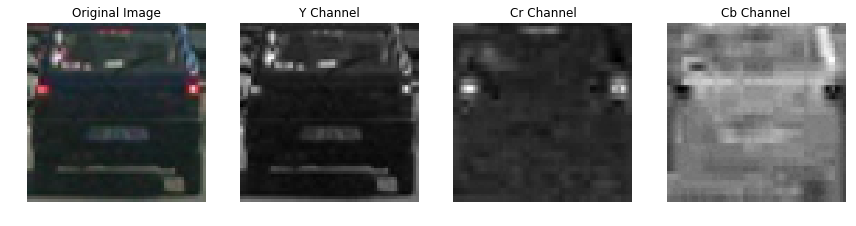

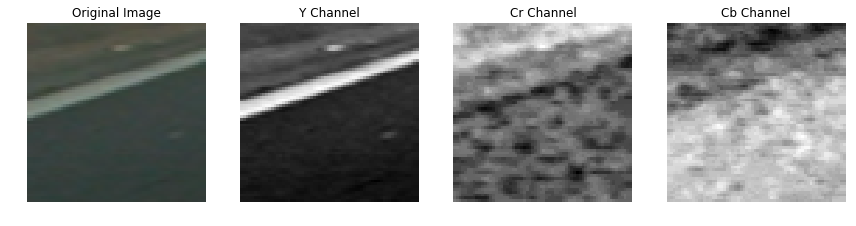

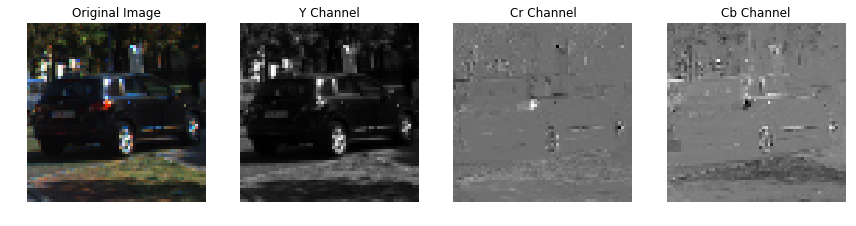

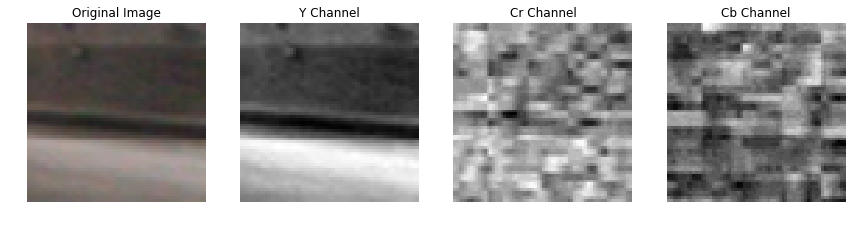

In [20]:
for i in train_vis_images:
    color_image = convert_color(i, conv='RGB2YCrCb')   
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(i)
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(142)
    plt.imshow(color_image[:,:,0], cmap='gray')
    plt.axis('off')
    plt.title('Y Channel')
    plt.subplot(143)
    plt.imshow(color_image[:,:,1], cmap='gray')
    plt.axis('off')
    plt.title('Cr Channel')
    plt.subplot(144)
    plt.imshow(color_image[:,:,2], cmap='gray')
    plt.axis('off')
    plt.title('Cb Channel')
    fig.tight_layout()

plt.show()

In [11]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
    
    results = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec)#,
#                           block_norm="L2-Hys")
    if(vis):
        return results[0], results[1]
    return results

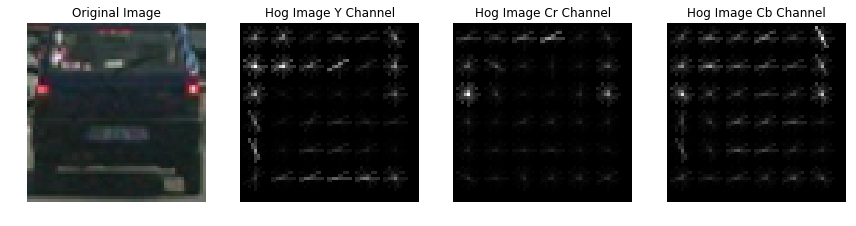

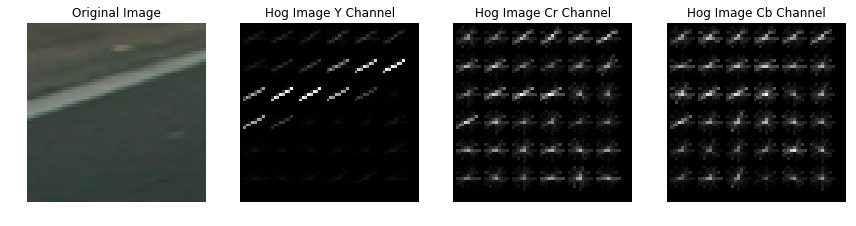

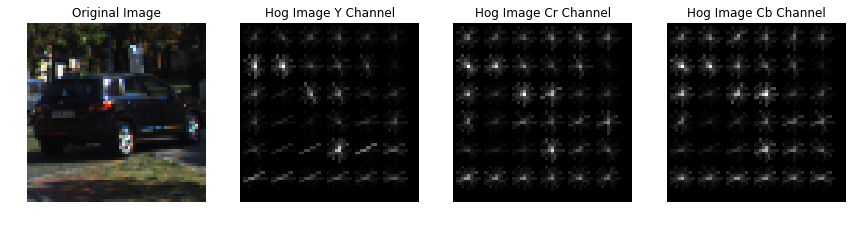

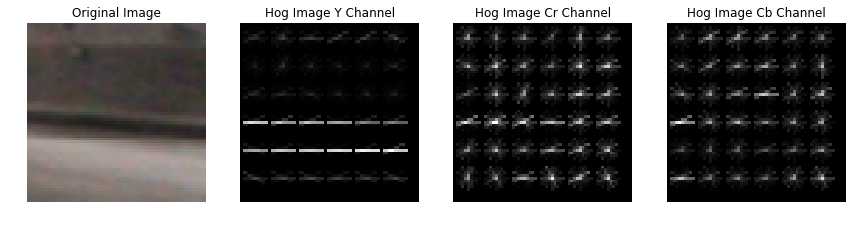

In [33]:
for image in train_vis_images:
    color_image = convert_color(image, conv='RGB2YCrCb') 
    feature_vc ,hog_imageY = get_hog_features(color_image[:,:,0], 12, 10, 2, vis=True, 
                     feature_vec=True)
    feature_vc ,hog_imageCr = get_hog_features(color_image[:,:,1], 12, 10, 2, vis=True, 
                     feature_vec=True)
    feature_vc ,hog_imageCb = get_hog_features(color_image[:,:,2], 12, 10, 2, vis=True, 
                     feature_vec=True)
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(142)
    plt.imshow(hog_imageY, cmap='gray')
    plt.axis('off')
    plt.title('Hog Image Y Channel')
    plt.subplot(143)
    plt.imshow(hog_imageCr, cmap='gray')
    plt.axis('off')
    plt.title('Hog Image Cr Channel')
    plt.subplot(144)
    plt.imshow(hog_imageCb, cmap='gray')
    plt.axis('off')
    plt.title('Hog Image Cb Channel')
    fig.tight_layout()

plt.show()

In [37]:
def color_hist(img, nbins=32, bins_range=(0, 1), rc=False):
    hist_1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist_2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist_3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    if rc:
        hist_features = np.array(([hist_1[0], hist_2[0], hist_3[0]]))
        bin_edges = hist_1[1]
        bin_center = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        return bin_center, hist_features
    else:
        return np.concatenate(([hist_1[0], hist_2[0], hist_3[0]]))

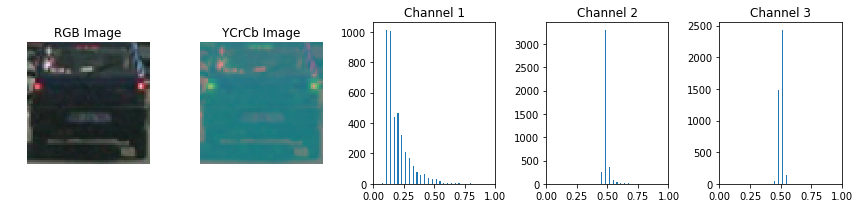

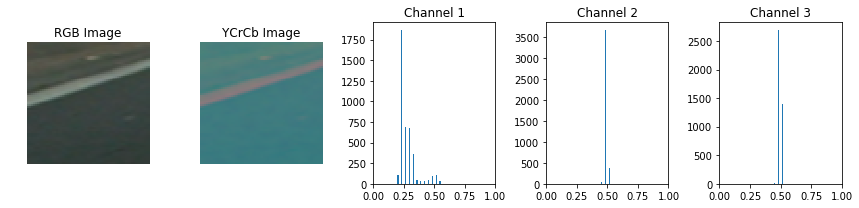

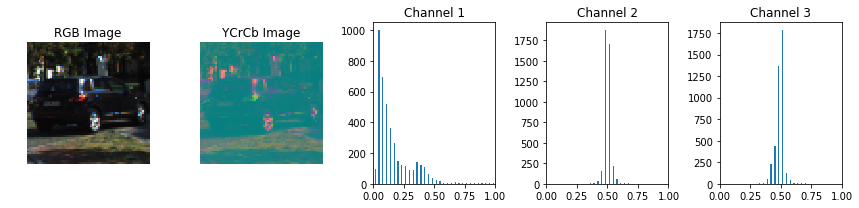

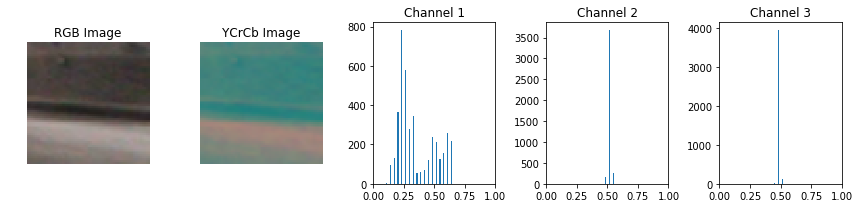

In [44]:
for image in train_vis_images:
    color_image = convert_color(image, conv='RGB2YCrCb')
    center, hist = color_hist(color_image, 32, rc=True)  
    fig = plt.figure(figsize=(12,3))
    plt.subplot(151)
    plt.imshow(image)
    plt.axis('off')
    plt.title('RGB Image')
    plt.subplot(152)
    plt.imshow(color_image)
    plt.axis('off')
    plt.title('YCrCb Image')
    plt.subplot(153)
    plt.xlim(0, 1)
    plt.title('Channel 1')
    plt.bar(center, hist[0], width = 0.01)
    plt.subplot(154)
    plt.bar(center, hist[1], width = 0.01)
    plt.xlim(0, 1)
    plt.title('Channel 2')
    plt.subplot(155)
    plt.bar(center, hist[2], width = 0.01)
    plt.xlim(0, 1)
    plt.title('Channel 3')
    fig.tight_layout()
plt.show()

In [48]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [49]:
bound_box = []

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,xstart):
    box_lst = []
    draw_img = np.copy(img)
    image_shape = img.shape
    img = img.astype(np.float32)/255
#     img_tosearch=img[:, xstart:xstop,:]
    img_tosearch = img[ystart:ystop,xstart:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis = False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis = False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis = False, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            f=[]
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
#             spatial_features = bin_spatial(subimg, size=(16,16))
            hist_features = color_hist(subimg, nbins=hist_bins)
#             print(spatial_features.shape)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features[4], hog_features)).reshape(1, -1)) 
#             test_features = X_scaler.transform(f.append(np.concatenate((spatial_features, hog_features))))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xstart + xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 bound_box.append((xbox_left, ytop_draw+ystart))
#                 bound_box.append((xbox_left+win_draw,ytop_draw+win_draw+ystart))
                box_lst.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)

                
    return box_lst
    
# ystart = [380,400,472,496,504]
# ystop =[476,560,560,656,672]
# scale = [1,1.5,2,,3]
# xstart = 575

# load a pe-trained svc model from a serialized (pickle) file
svc_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
# get attributes of our svc object
svc = svc_pickle["svc"]
X_scaler = svc_pickle["scaler"]
orient = svc_pickle["orient"]
pix_per_cell = svc_pickle["pix_per_cell"]
cell_per_block = svc_pickle["cell_per_block"]
spatial_size = svc_pickle["spatial_size"]
hist_bins = svc_pickle["hist_bins"]
color_space = svc_pickle["colorspace"]
hog_channel = svc_pickle["hog_channel"]


In [50]:
ystart = [380,400,472,496,504]
ystop =[476,560,560,656,672]
scale = [1,1.5,2,2.5,3]
xstart = 600
flag =0
counter =1
print("Cars With Bounding Boxes")
def PipelineForVideo(img):
    bbox_lst1=[]
    for i in range(len(scale)):
        bbox_lst = find_cars(img, ystart[i], ystop[i], scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block,xstart)
        bbox_lst1+=bbox_lst
#     res_img = heatmap(img,bbox_lst1)
        out_img = draw_boxes(img,bbox_lst1)    
    return out_img

Cars With Bounding Boxes


In [52]:
img = mpimg.imread(test_imgs[0])
# for i in test_imgs:
#     img = mpimg.imread(i)
res_image = PipelineForVideo(img)
#     output.append(res_image)


plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.title('Test Image')
plt.subplot(122)
plt.imshow(res_image)
plt.axis('off')
plt.title('Output Image with bounding boxes')
plt.tight_layout()
plt.show()
    

ValueError: operands could not be broadcast together with shapes (1,3601) (3696,) (1,3601) 